In [95]:
using Revise
using CMBLensing
using CMBLensing: get_ℓ⁴Cℓ, HP, LP, Field, Flat, fieldvalues, S0, S2
using CMBFieldsBase
using JLD
using PyPlot
using Parameters
using PyCall
@pyimport seaborn.apionly as sns

In [2]:
rc("xtick",top=true,bottom=true,direction="in",labelsize=12)
rc("ytick",left=true,right=true,direction="in",labelsize=12)
rc("axes",labelsize=16,titlesize=16)
rc("legend",frameon=false,fontsize=12)
rc("figure",figsize=(6.4,4.8))

# Unmasked

## Load

In [4]:
# dat = load("../dat/run2_256_3_teb_r05_lf7_20wauto.jld")

# @unpack T,Θpix,nside,ϕ,f,f̃,d = dat["rundat"]
# @unpack fcur,f̃cur,ϕcur = dat["trace"][end]

# fest,f̃est,ϕest = fcur,f̃cur,ϕcur
# ϕtrue,ftrue,f̃true = ϕ,f,f̃;

In [179]:
dat = load("../dat/run2_1024_3_teb_r05_lf7_30wauto_seed0.jld")
# dat = load("../dat/run2_512_3p_3b_eb_r05_lf7_mask_20wauto_seed0.jld")
# dat = load("../dat/run2_512_3p_3b_eb_r05_lf7_mask_20wauto_seed0_lmaxhack2000.jld")

@unpack T,Θpix,nside,Cℓf,Cℓn,ϕ,f,f̃,d = dat["rundat"]
@unpack fcur,f̃cur,ϕcur = dat["trace"][end]
Cℓf̃ = Dict(k=>Cℓf[Symbol("ln_$k")] for (k,v) in Cℓf if Symbol("ln_$k") in keys(Cℓf))

fest,f̃est,ϕest = fcur,f̃cur,ϕcur
ϕtrue,ftrue,f̃true = ϕ,f,f̃;

In [180]:
# t = 2dat["rundat"][:target_lnP]
# (-2dat["trace"][end][:lnP] - t) / sqrt(2t)

In [181]:
t = -2dat["rundat"][:target_lnP]
(-2dat["trace"][end][:lnP1] - t) / sqrt(2t)

-1.7448212f0

## Plots

### ϕ

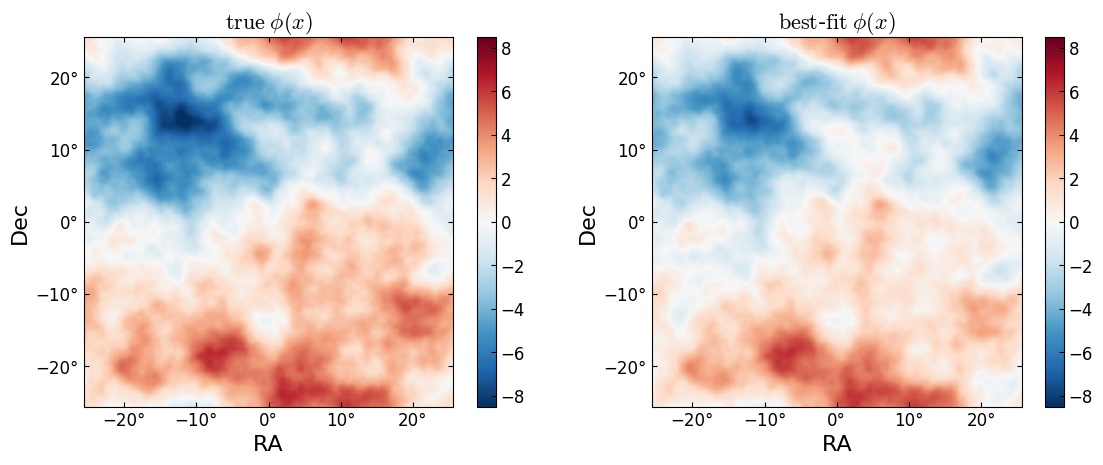

In [185]:
_,axs = plot(1e5.*[ϕtrue,ϕest]',vlim=8.5)
axs[1][:set_title](raw"${\rm true}\;\phi(x)$")
axs[2][:set_title](raw"${\rm best}$"*"-"*raw"${\rm fit}\;\phi(x)$")
savefig("../paper/figs/phiest.pdf",bbox_inches="tight")

### B

In [183]:
P = Flat{Θpix,nside}
Cf = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf[k] for k=(:tt,:ee,:bb,:te))...)
Cf̃ = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf̃[k] for k=(:tt,:ee,:bb,:te))...)
Cn = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓn[k] for k=(:tt,:ee,:bb,:te))...);

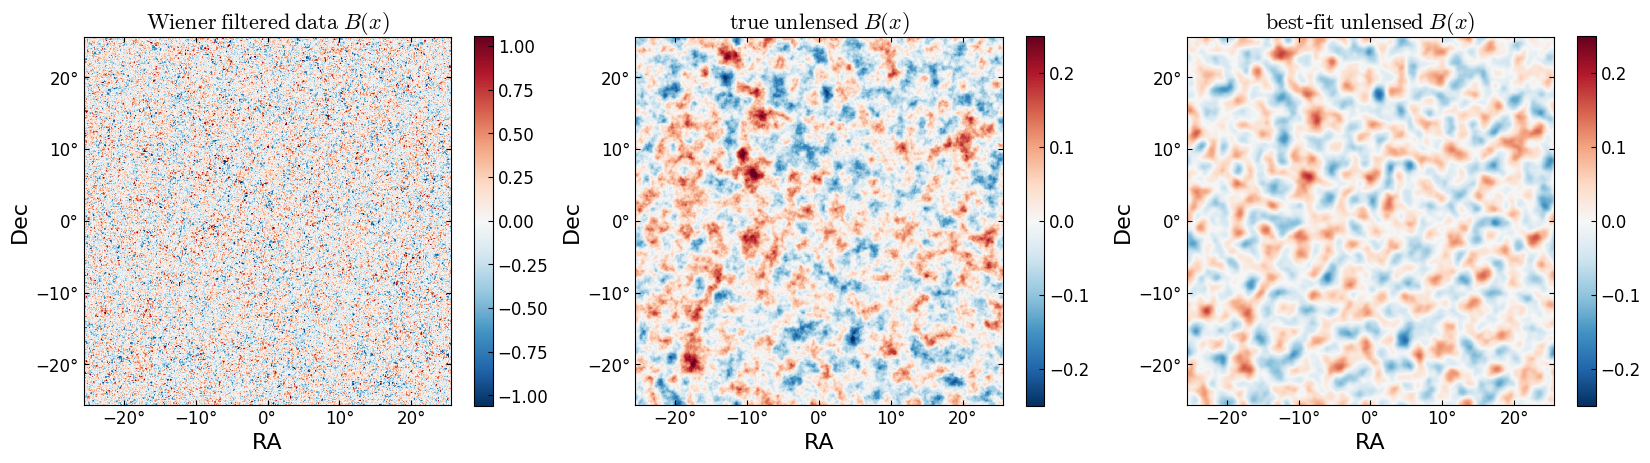

In [186]:
_,axs = plot([nan2zero.(𝕎(Cf̃,Cn)*d),f,fcur]',which=[:Bx])
axs[1][:set_title](raw"${\rm Wiener\;filtered\;data}\;B(x)$")
axs[2][:set_title](raw"${\rm true\;unlensed}\;B(x)$")
axs[3][:set_title](raw"${\rm best}$-${\rm fit\;unlensed}\;B(x)$")

vlim = 0.25
axs[2][:get_children]()[end-1][:set_clim](-vlim,vlim)
axs[3][:get_children]()[end-1][:set_clim](-vlim,vlim)

savefig("../paper/figs/Best.pdf",bbox_inches="tight")

### Powerspec difference

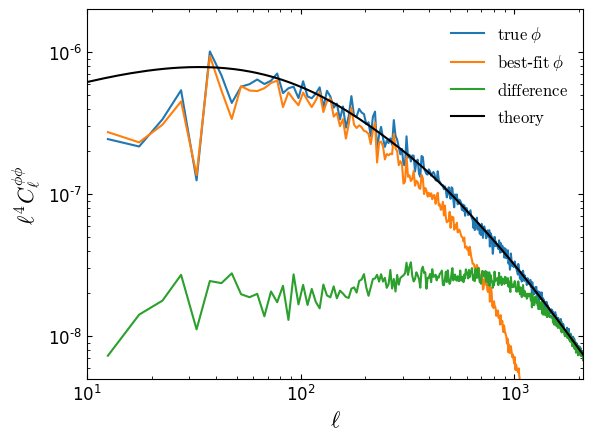

PyObject <matplotlib.text.Text object at 0x7fb0d4eb3908>

In [134]:
let Δℓ=5,
    ℓedges=10:Δℓ:16000;
    loglog(get_ℓ⁴Cℓ(ϕtrue,Δℓ=Δℓ,ℓedges=ℓedges)..., label=raw"$\rm true \; \phi$")
    loglog(get_ℓ⁴Cℓ(ϕest,Δℓ=Δℓ,ℓedges=ℓedges)...,label=raw"$\rm best$-$\rm fit\; \phi$")
    loglog(get_ℓ⁴Cℓ(ϕest-ϕtrue,Δℓ=Δℓ,ℓedges=ℓedges)..., label=raw"$\rm difference$")
    loglog((@. Cℓf[:ℓ]^2*(Cℓf[:ℓ]+1)^2*Cℓf[:ϕϕ]),"k", label=raw"$\rm theory$")
    legend(loc="upper right")
    ylim(5e-9,2e-6)
#     ylim(1e-5,1e-3)
end
xlim(10,2100)
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell^{\phi \phi}$")

# savefig("../paper/figs/phispec.pdf",bbox_inches="tight")

### trace

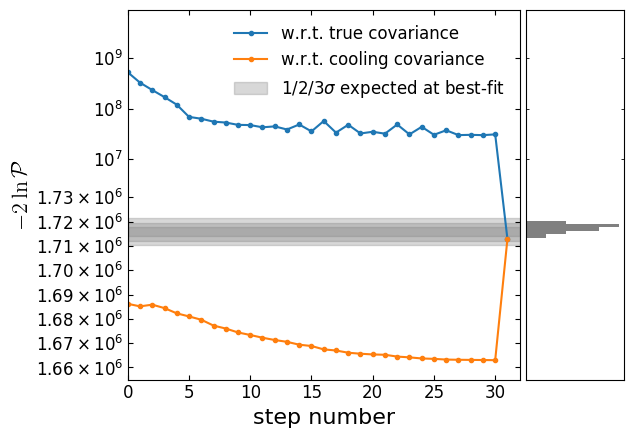

In [287]:
rc("mathtext",fontset="dejavusans")

g = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
ax = subplot(g[1])

plot(-2getindex.(dat["trace"],:lnP1),".-",label=raw"w.r.t. true covariance")
plot(-2getindex.(dat["trace"],:lnPw),".-",label=raw"w.r.t. cooling covariance")

t = -2mean(load("../dat/target_lnPs_1024_3_teb_lmaxdat3000.jld","target_lnPs"))
for y=1:3
    fill_between([0,length(dat["trace"])], (fill(t+y*x*sqrt(2t),2) for x=[1,-1])..., 
            color="gray", alpha=0.3, label=y==1?raw"1/2/3$\sigma$ expected at best-fit":nothing)
end

legend(loc="upper right")

xlabel("step number")
ylabel(raw"$-2\ln\mathcal{P}$",usetex=true)


yscale("symlog",linthreshy=1.73e6,linscaley=75)
ylim(1.655e6,9e9)
xlim(0,32)
ax[:set_yticks]([(1.66:0.01:1.73)*1e6;1e7;1e8;1e9])
ax[:set_yticklabels]([[@sprintf("\$%.2f \\times 10^6\$",x) for x=(1.66:0.01:1.73)];["\$10^$i\$" for i=7:9]])
ax[:set_xticks](0:5:31)

ax = subplot(g[2])
χ²s = -2load("../dat/lnPs.jld","lnPs")
ax[:hist](χ²s, bins=5, orientation="horizontal", color="gray")#plt[:rcParams]["axes.prop_cycle"][:by_key]()["color"][3])
yscale("symlog",linthreshy=1.73e6,linscaley=75)
ylim(1.655e6,9e9)
ax[:set_yticks]([])
ax[:set_xticks]([])

subplots_adjust(wspace=0.025)

savefig("../paper/figs/lnPtrace.pdf",bbox_inches="tight")

# Masked

## Load

In [189]:
T = Float64
P = Flat{2,512};

In [190]:
# dat = load("../dat/ethan/sim_out512_3p0.jld");

In [191]:
dat = load("../dat/ethan/test_with_masking_v2_0x5385d718219193ec_512_2p0.jld")

Dict{String,Any} with 19 entries:
  "cl"               => CMBFieldsBase.Cl{CMBFieldsBase.Flat{2.0,512},Float64}([…
  "lncl"             => CMBFieldsBase.Cl{CMBFieldsBase.Flat{2.0,512},Float64}([…
  "ncl_invbeam"      => CMBFieldsBase.Cl{CMBFieldsBase.Flat{2.0,512},Float64}([…
  "nside"            => 512
  "bFWHM_rad"        => 0.000581776
  "Px"               => CMBFieldsBase.Flat{2.0,512}
  "Tx"               => Float64
  "lntpϕₒ"           => JLD.##Lense.TPΦ{1,CMBFieldsBase.Flat{2.0,512},Core.Floa…
  "Θpix"             => 2.0
  "tpϕ_unlensed_cls" => JLD.##Lense.TPΦ{0,CMBFieldsBase.Flat{2.0,512},Core.Floa…
  "tpϕₒ"             => JLD.##Lense.TPΦ{0,CMBFieldsBase.Flat{2.0,512},Core.Floa…
  "dtpϕ"             => JLD.##Lense.TPΦ{1,CMBFieldsBase.Flat{2.0,512},Core.Floa…
  "ncl"              => CMBFieldsBase.Cl{CMBFieldsBase.Flat{2.0,512},Float64}([…
  "μKarcminT"        => 1.0
  "tpϕWF"            => JLD.##Lense.TPΦ{0,CMBFieldsBase.Flat{2.0,512},Core.Floa…
  "𝓂IQU"            => [1.0 1.0 …

type Lense.TPΦ{0,CMBFieldsBase.Flat{2.0,512},Core.Float64} not present in workspace; reconstructing


In [192]:
Θpix,nside = 2,512;

In [193]:
fshift(f) = (f=Ł(f); typeof(f)(map(fftshift,fieldvalues(f))...))

fshift (generic function with 1 method)

In [194]:
ϕtrue = FlatS0Fourier{T,P}(dat["lntpϕₒ"].ϕ.Il) |> fshift;
ϕest = FlatS0Fourier{T,P}(dat["tpϕ_curr0"].ϕ.Il) |> fshift;
ftrue = FieldTuple(fshift(FlatS0Fourier{T,P}(dat["tpϕₒ"].t.Il)),fshift(FlatS2EBFourier{T,P}(fieldvalues(dat["tpϕₒ"].p)...)));
fest = FieldTuple(fshift(FlatS0Fourier{T,P}(dat["tpϕ_curr0"].t.Il)),fshift(FlatS2EBFourier{T,P}(fieldvalues(dat["tpϕ_curr0"].p)...)));
d = FieldTuple(fshift(FlatS0Fourier{T,P}(dat["dtpϕ"].t.Il)),fshift(FlatS2EBFourier{T,P}(fieldvalues(dat["dtpϕ"].p)...)));

## Plots

### ϕ

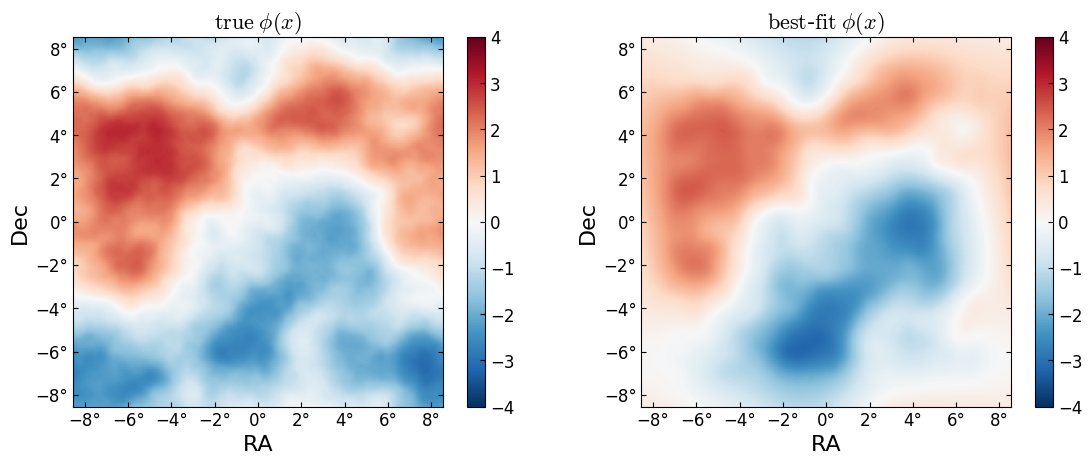

In [150]:
_,axs = plot(1e5.*[ϕtrue,ϕest]',vlim=4)
axs[1][:set_title](raw"${\rm true}\;\phi(x)$")
axs[2][:set_title](raw"${\rm best}$"*"-"*raw"${\rm fit}\;\phi(x)$")
savefig("../paper/figs/phiest_masked.pdf",bbox_inches="tight")

### B

In [195]:
P = Flat{Θpix,nside}
Cf = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf[k] for k=(:tt,:ee,:bb,:te))...)
Cf̃ = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf̃[k] for k=(:tt,:ee,:bb,:te))...)
Cn = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓn[k] for k=(:tt,:ee,:bb,:te))...);

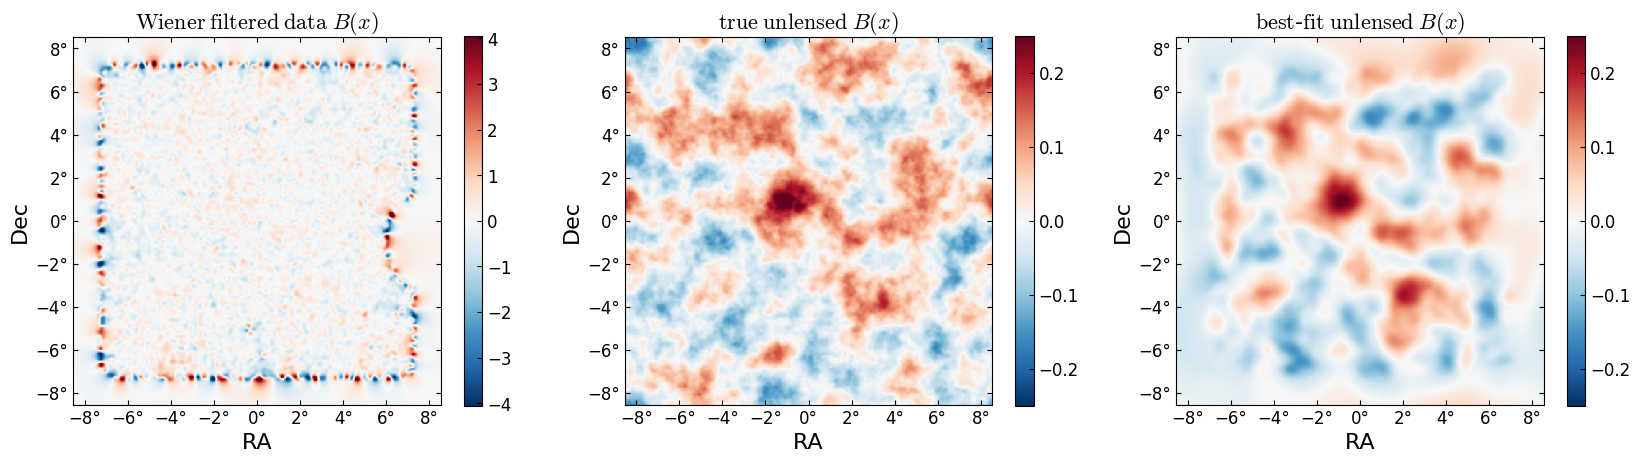

In [196]:
_,axs = plot([nan2zero.(𝕎(Cf̃,Cn)*d),ftrue,fest]',which=[:Bx])
# _,axs = plot([nan2zero.(𝕎(Cf,Cn+(Cf̃-Cf))*d),ftrue,fest]',which=[:Bx])
axs[1][:set_title](raw"${\rm Wiener\;filtered\;data}\;B(x)$")
axs[2][:set_title](raw"${\rm true\;unlensed}\;B(x)$")
axs[3][:set_title](raw"${\rm best}$-${\rm fit\;unlensed}\;B(x)$")

vlim = 0.25
axs[2][:get_children]()[end-1][:set_clim](-vlim,vlim)
axs[3][:get_children]()[end-1][:set_clim](-vlim,vlim)

savefig("../paper/figs/Best_masked.pdf",bbox_inches="tight")

# Scratch